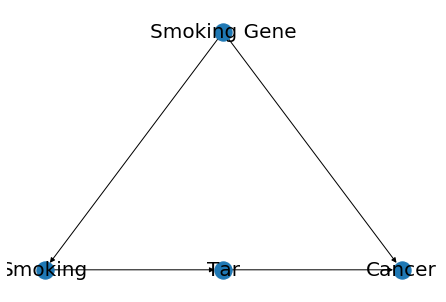

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import shapely.geometry as SG
import random
import networkx as nx
#graph adjacency matrix 
nod= np.matrix([[0, 1, 0, 0],
               [0, 0, 1, 0],
               [0, 0, 0, 0],
               [1, 0, 1, 0]])

##  node coordinates on the xy plan
coords = np.array([[20, 0],
               [60, 0],
               [100, 0], 
               [60, 20]]) 

G = nx.from_numpy_matrix(np.array(nod), create_using = nx.MultiDiGraph())
pos = coords
nx.draw(G,pos)
labels = {0:'Smoking',1:'Tar',2:'Cancer',3:'Smoking Gene'}

nx.draw_networkx_labels(G, pos, labels, font_size=20, arrows=True)
plt.show()


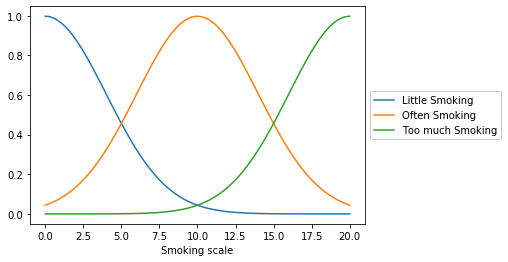

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import shapely.geometry as SG
import random
import scipy.stats as stats
import math
#In this example we are going to proceed as if the variables are 0-10 scaled
#this part is aiming to plot the Smoking graph
x = np.linspace(0, 20, 100)
plt.plot(x, 10*stats.norm.pdf(x,0,4),label='Little Smoking')
x = np.linspace(0, 20, 100)
plt.plot(x, 10*stats.norm.pdf(x, 10,4),label='Often Smoking ')
plt.plot(x,10*stats.norm.pdf(x,20,4),label='Too much Smoking')
plt.legend(framealpha=1, frameon=True,loc='center left', bbox_to_anchor=(1, 0.5));

plt.xlabel('Smoking scale')                                                                   

plt.show()                                                                  


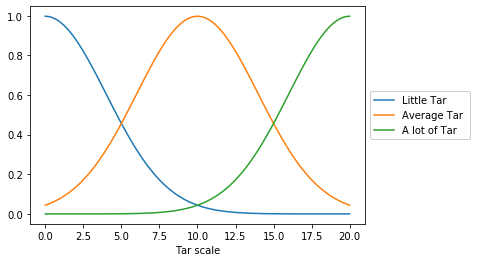

In [4]:
x = np.linspace(0, 20, 100)
plt.plot(x, 10*stats.norm.pdf(x,0,4),label='Little Tar')
x = np.linspace(0, 20, 100)
plt.plot(x, 10*stats.norm.pdf(x, 10,4),label='Average Tar ')
plt.plot(x,10*stats.norm.pdf(x,20,4),label='A lot of Tar')
plt.legend(framealpha=1, frameon=True,loc='center left', bbox_to_anchor=(1, 0.5));

plt.xlabel('Tar scale')                                                                   

plt.show()

In [12]:
def get_ylabel(value): 
  #this function aims to fuzzify the input
   # i.e transform a 0-10 scale to a fuzzy value 
    #between 0 and 1 following the more likelyhood state 
    
    l=list()
    x = np.linspace(0, 20, 100)
    xvalues=[x,x,x]
    yvalues=[5*stats.norm.pdf(x,0,2),5*stats.norm.pdf(x,10,2),5*stats.norm.pdf(x,20,2)]
    for i in range(3):
      if value>=xvalues[i][0] and value<=xvalues[i][-1]:
        l.append(np.interp(value, xvalues[i],yvalues[i]))
    a=sorted(l)
    return a[-1] 




def membership_vector(value):
  #return the membership vector for determining the outcome using the rules
    l=list()
    vector=list()
    x = np.linspace(0, 20, 100)
    xvalues=[x,x,x]
    yvalues=[5*stats.norm.pdf(x,0,2),5*stats.norm.pdf(x,10,2),5*stats.norm.pdf(x,20,2)]

    for i in range(3):
        l.append(np.interp(value, xvalues[i],yvalues[i]))
    a=sorted(l)
    for i in range(3):
        if i==l.index(a[-1]):
          vector.append(1)
        else :
          vector.append(0)
    return vector 



def deffuzification(cancer_vector,cancer) :
#we will return the centroid of the four point that we got by explointing the funtion parameters
    x = np.linspace(0, 100, 500)
    xvalues=[x,x,x]
    yvalues=[5*stats.norm.pdf(x,0,10),5*stats.norm.pdf(x,10,10),5*stats.norm.pdf(x,20,2)]
    average =[0,1,0]
    little=[1,0,0] 
    dangerous=[0,0,1]
    if np.all(cancer_vector==average) :
        x1=[0,50,100]
        y=50*stats.norm.pdf(x,50,20)
    elif np.all(cancer_vector==little):
        x1=[0,50]
        y=50*stats.norm.pdf(x,0,20)
    elif np.all(cancer_vector==dangerous):
        x1=[50,100]
        y=50*stats.norm.pdf(x,100,20)


    line = SG.LineString(list(zip(x,y)))
    y0 = cancer
    yline = SG.LineString([(min(x), y0), (max(x), y0)])
    coords = np.array(line.intersection(yline))   
    if coords.ndim==2 :
      if cancer<0.5 :
        centroid = coords[0,0]
      else :
        centroid=coords[1,0]
    elif coords.ndim==1 :
        if np.all(cancer_vector==little):
        
            centroid=(coords[0]+2*x1[0]+x1[-1])/4
        else :
            centroid=(coords[0]+x1[0]+2*x1[-1])/4
    return centroid,coords
print(deffuzification([1,0,0],0.4))

(19.258869779551052, array([27.03547912,  0.4       ]))


In [0]:
#####################################################################
# in this part we are going to add mutiple concepts with different  #
#impact on the fuzzification process :                              #
#internal pollution : [0,20] TO [0,1]                                #
#interval of smoking gene : [0,20] to [0,1]                          #
#interval of healthy life style : [0,20] to [1,0]                    #
#####################################################################
#we will define a bunch of rules that will apply in case that we want 
#to increase or decrease the final result

def monotonic_inc(x):
    dx = np.diff(x)
    return  np.all(dx >= 0)
'''the reverse function tries to predict the concepts that can reduces or increase our causal effect '''
def reverse_causal(cancer_vector,cancer_percentage,new_cancer_percentage,smoking,tar):
    average =[0,1,0]
    little=[1,0,0] 
    dangerous=[0,0,1]
    if np.all(cancer_vector==average) :
        x=[0,50,100]
        y=[0,1,0]
    elif np.all(cancer_vector==little):
        x=[0,50]
        y=[1,0]
    elif np.all(cancer_vector==dangerous):
        x=[50,100]
        y=[0,1]
    value=np.interp(new_cancer_percentage,x,y)
    data=['pollution','smoking gene','healthy life style']
    x_data=[[0,20],[0,20],[0,20]]
    y_data=[[0,0.8],[0,1],[1,0]]
    #by default all the this 3 concepts are set to 0 
    data_increasing=list()
    x_data_increasing=list()
    y_data_increasing=list()
    data_decreasing=list()
    x_data_decreasing=list()
    y_data_decreasing=list()
    for i in range (len(data)):
        if monotonic_inc(y_data[i]):
            x_data_increasing.append(x_data[i]) 
            y_data_increasing.append(y_data[i])
            data_increasing.append(data[i])
        else :
            data_decreasing.append(data[i])
            x_data_decreasing.append(x_data[i])
            y_data_decreasing.append(y_data[i])
    
    valid_concepts=list() 
    x_valid_concepts=list()
    y_valid_concepts=list()
    #############################################################################
    #In this part we will consider that all the concepts have   the same weights :
    if new_cancer_percentage>cancer_percentage:
        for i in range(len(data_increasing)):
    #defining a random rule (tip= (get_label(tar)+get_ylabel(smoking)+max_concepts)/3)
            if min(2, get_ylabel(tar)+y_data_increasing[i][-1]) > value :
                valid_concepts.append(data_increasing[i])
                x_valid_concepts.append(x_data_increasing[i])
                y_valid_concepts.append(y_data_increasing[i])
                
    else :
        for i in range(len(data_decreasing)):
             if  min(2, get_ylabel(tar)+y_data_increasing[i][-1]) < value :
                valid_concepts.append(data_decreasing[i])
                x_valid_concepts.append(x_data_decreasing[i])
                y_valid_concepts.append(y_data_decreasing[i])
    answer=list()            
    for i in range(len(valid_concepts)):
        
        if get_ylabel(tar)==value:
          x=1-value+0.01
        else :
          x=1-value
        answer.append(valid_concepts[i])
        answer.append(np.interp(x,y_valid_concepts[i],x_valid_concepts[i]))

      
    return answer
def gene(cancer_vector,cancer_percentage,new_cancer_percentage,smoking,tar):
  if 'smoking gene' in reverse(cancer_vector,cancer_percentage,new_cancer_percentage,smoking,tar):
    return 'with effect',reverse(cancer_vector,cancer_percentage,new_cancer_percentage,smoking+random.uniform(0,1),tar)
  else:
    return 'no effect'



def association(value):
    if np.all(membership_vector(value)==[0,0,1]):
      return min(value,0.5)
    elif np.all(membership_vector(value)==[0,1,0]):
      return min(0.75,value)
    else :
      return min(value,1) 



'''In this part we will model the impact of smoking gene on the smoking and the cancer'''
def cause(smoking_gene,smoking):
  '''the elimination rule to reduce the effect of the smoking gene on the smoking'''
  '''the association rule to highlight the effect of the smoking gene ''' 
  poss_smoking =[min(1-get_ylabel(smoking_gene),get_smoking(smoking)),max(get_smoking(smoking),get_ylabel(smoking_gene)) ]
  #here we are calculationg once the minimum influence of cancer (poss_smoking[0]) and the maximum influence of cancer to smoking (poss_smoking[1]) 
  poss_tar=[max(poss_smoking[0],get_ylabel(smoking_gene)),min(poss_smoking[1],1-get_ylabel(smoking_gene))]


  if  np.all(membership_vector(smoking)==[1,0,0]) or np.all(membership_vector(smoking_gene)==[1,0,0]) :
    cancer_vector=[1,0,0]
  elif np.all(membership_vector(smoking)==[0,1,0]) or np.all(membership_vector(smoking_gene)==[0,1,0]):
    cancer_vector=[0,1,0]
  elif  np.all(membership_vector(smoking)==[0,0,1]) or  np.all(membership_vector(smoking_gene)==[0,0,1]) :
    cancer_vector=[0,0,1]


  cancer=[min(get_ylabel(smoking_gene),poss_tar[0]),min(1,1-get_ylabel(smoking_gene)+poss_tar[1])]
  cancer_percentage=deffuzification(cancer_vector,cancer[0])
  cancer_percentage1=deffuzification(cancer_vector,cancer[1])

  #the output  is the value of then cancer of percentage 
  return 'first rule ouput',cancer_percentage,'second rule output',cancer_percentage1,cancer[0],cancer[1]
  '''the first element represents the cancer percentage if we intervene to cut the causal effect of the smoking gene on the smoking '''
  '''the second is when we take in consideration the smoking_gene - smoking connection'''




('first rule ouput', 75.27529131450814, 'second rule output', 87.5, 0.022023305160650365, 1)


0.8801569515708372


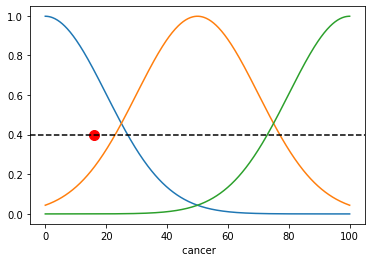

In [0]:
figure3,ax3=plt.subplots(1) 
x = np.linspace(0, 100, 500)
yvalues=[2.5*stats.norm.pdf(x,0,2),2.5*stats.norm.pdf(x,10,2),2.5*stats.norm.pdf(x,20,2)]
ax3.plot(x, 50*stats.norm.pdf(x,0,20),label='small p(cancer)')
ax3.plot(x,  50*stats.norm.pdf(x,50,20),label='medium p(cancer)')
ax3.plot(x,  50*stats.norm.pdf(x,100,20),label='high p(cancer)')
plt.xlabel('cancer scale')                                                                   
ax3.set_xlabel(' cancer')
ax3.axhline(y=0.4, color='black', linestyle='--')
ax3.scatter(15.87,0.4,s=100,c='red')

print(np.interp(5,x,25*stats.norm.pdf(x,0,10)))

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy
study_set = pd.DataFrame({'averge smoked cigaretes ' :[0,0,3,3,10,10,20,20],'No patients' : [57,32,29, 19, 62, 71,52,90],'cancer' : [0,1,0, 1, 0, 1,0,1]})

study = pd.DataFrame([study_set.loc[:,'No patients'].sum()])
study_set['pos cancer diag']=study_set['cancer']>0.5
study_set['percentage'] = study_set['No patients'].apply(lambda x: x/study_set.loc[:,'No patients'].sum())
print(study_set)
'''computing the conditional probability of each event '''
#P(c=1|smoking=little)
p1=study_set.iloc[3,1]/(study_set.iloc[2,1]+study_set.iloc[3,1])
#P(c=1|smoking=average)
p2=study_set.iloc[5,1]/(study_set.iloc[4,1]+study_set.iloc[5,1])
#P(c=1|smoking=a lot)
p3=study_set.iloc[7,1]/(study_set.iloc[7,1]+study_set.iloc[6,1])
print('P(c=1|smoking=little)=',p1)
print('P(c=1|smoking=average)=',p2)
print('P(c=1|smoking=alot)=',p3)

print(study_set.iloc[3,1],study_set.iloc[2,1],study_set.iloc[3,1])

   averge smoked cigaretes   No patients  cancer  pos cancer diag  percentage
0                         0           57       0            False    0.138350
1                         0           32       1             True    0.077670
2                         3           29       0            False    0.070388
3                         3           19       1             True    0.046117
4                        10           62       0            False    0.150485
5                        10           71       1             True    0.172330
6                        20           52       0            False    0.126214
7                        20           90       1             True    0.218447
P(c=1|smoking=little)= 0.3958333333333333
P(c=1|smoking=average)= 0.5338345864661654
P(c=1|smoking=alot)= 0.6338028169014085
19 29 19
